In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time


#import empirical cdf
import sys
sys.path.append('../')

from check_ecdf import get_empirical_cdf
from core import Config



In [8]:
#experiment details
config = Config()
trainA = config.dataset_typ
valA = config.val_dataset_typ
num_val_systems = config.num_val_tasks
context_len = config.n_positions
print('context_len:', context_len)
print('trainA:', trainA)
print('valA:', valA)
C_dist = config.C_dist
ckpt_step = 192000
experiment = '240923_201715.03463b_single_system_single_system'


context_len: 250
trainA: single_system
valA: single_system


In [3]:
#print the absolute path of the experiment
print(os.path.abspath(f"../../../../outputs/GPT2/{experiment}/prediction_errors{C_dist}_step={str(ckpt_step)}.ckpt/{valA}_err_lss.pkl"))

#load prediction errors

with open(f"../../../../outputs/GPT2/{experiment}/prediction_errors{C_dist}_step={str(ckpt_step)}.ckpt/{valA}_err_lss.pkl", 'rb') as f:
    err_lss = pickle.load(f)


/Users/sultandaniels/Documents/Transformer_Kalman/outputs/GPT2/240923_201715.03463b_single_system_single_system/prediction_errors_single_system_step=192000.ckpt/single_system_err_lss.pkl


In [4]:
for key in err_lss.keys():
    print(key, err_lss[key].shape)

Kalman (3, 2000, 251)
MOP (3, 2000, 251)
MOP_analytical (3, 2000, 251)
Zero (3, 2000, 251)
Analytical_Kalman (3, 250)
OLS_ir_1 (3, 2000, 251)
OLS_analytical_ir_1 (3, 2000, 251)
OLS_ir_2_unreg (3, 2000, 251)
OLS_analytical_ir_2_unreg (3, 2000, 251)
OLS_ir_2 (3, 2000, 251)
OLS_analytical_ir_2 (3, 2000, 251)
OLS_ir_3 (3, 2000, 251)
OLS_analytical_ir_3 (3, 2000, 251)


[ 50 150 250]
MOP (3, 2000, 251)
idx: 50
idx: 150
idx: 250
Analytical_Kalman (3, 250)
(6000, 251)
idx: 50
idx: 150
idx: 250
OLS_ir_1 (3, 2000, 251)
idx: 50
idx: 150
idx: 250
OLS_ir_2 (3, 2000, 251)
idx: 50
idx: 150
idx: 250
OLS_ir_3 (3, 2000, 251)
idx: 50
idx: 150
idx: 250


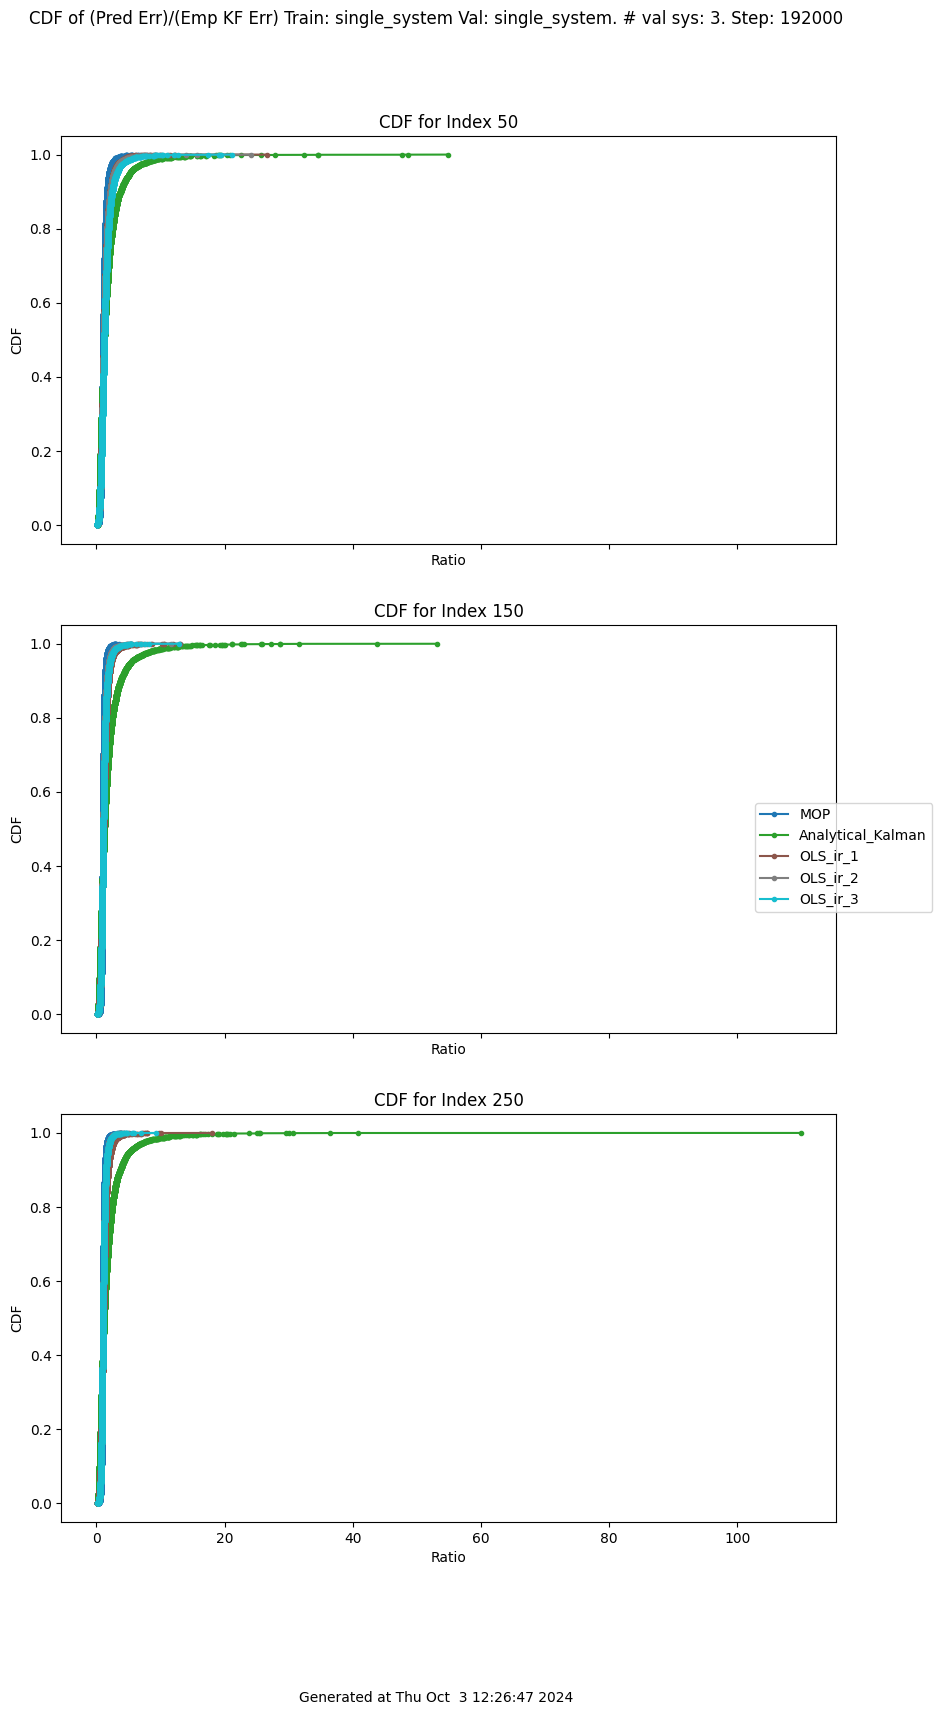

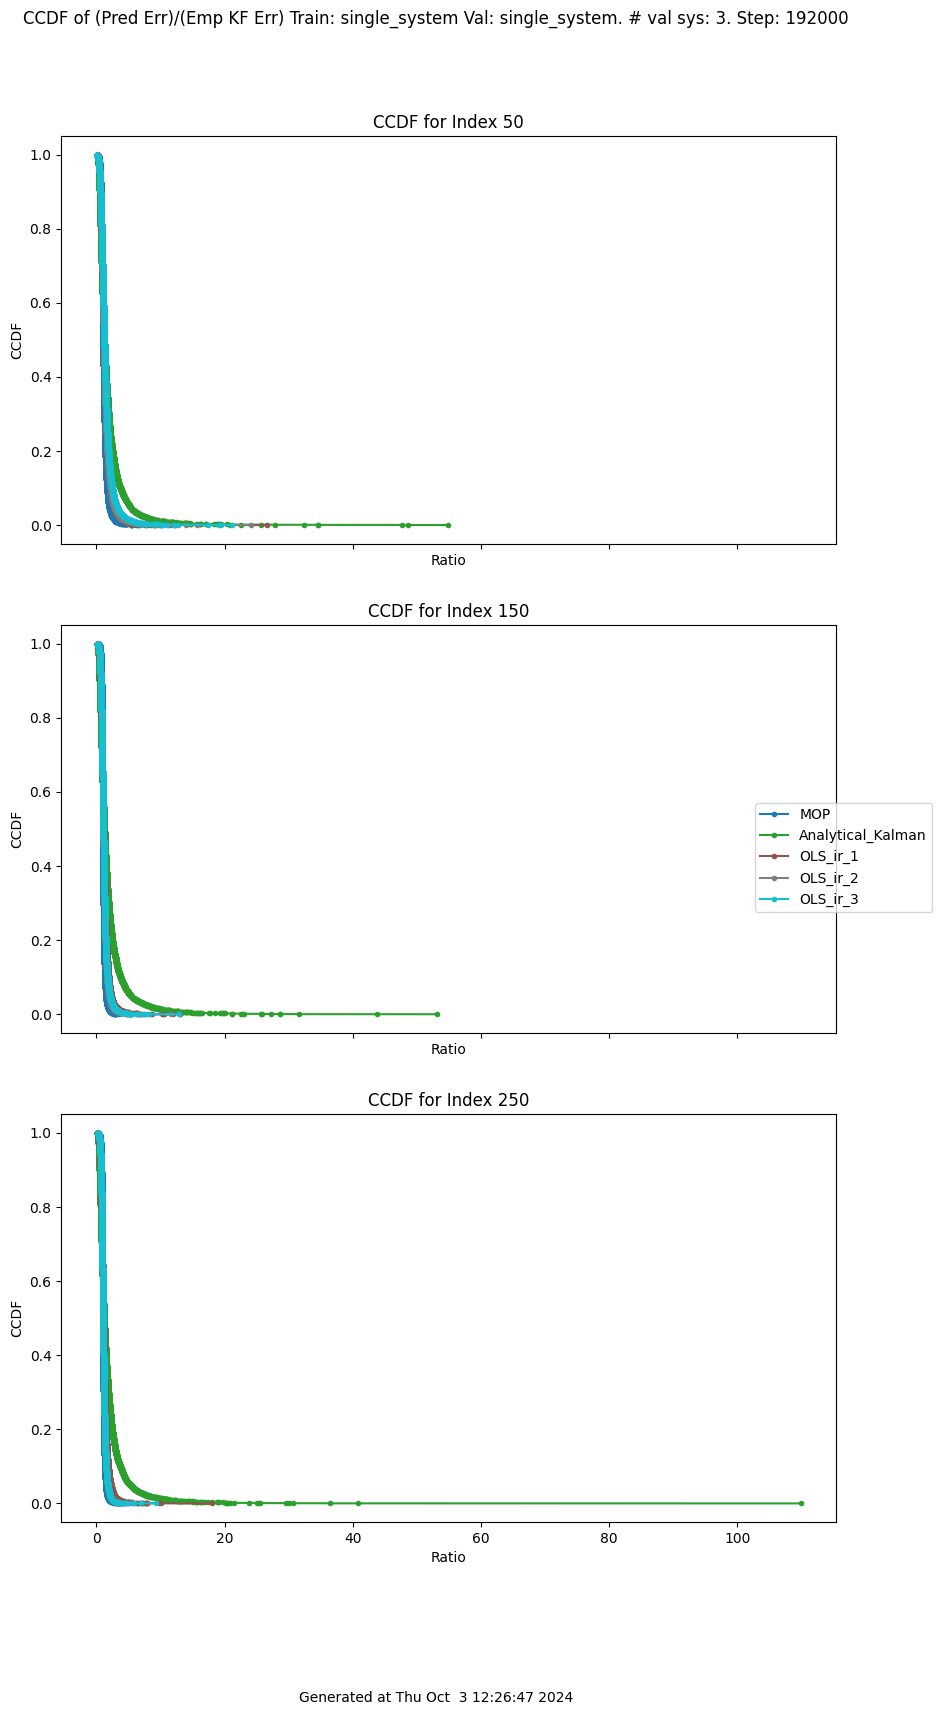

In [59]:
#give a list of colors that is as long as the len of err_lss.keys()
colors = plt.cm.tab10(np.linspace(0, 1, 5))

m = 3
# choose m evenly spaced indexes between 50 and context_len
idxs = np.linspace(50, context_len, m).astype(int)
print(idxs)

#create a figure with subplots for each of the m indexes for the cdfs
fig_cdf, ax_cdf = plt.subplots(m, 1, figsize=(10, 18), sharex=True)

#create a figure with subplots for each of the m indexes for the ccdfs
fig_ccdf, ax_ccdf = plt.subplots(m, 1, figsize=(10, 18), sharex=True)

handles_cdf = []
handles_ccdf = []
labels = []

col = 0
for (name, errs) in err_lss.items():

    plot_flag = False
    if not (name == "Analytical_Kalman" or name == "Kalman" or name == "OLS_ir_2_unreg" or "analytical" in name or name == "Zero"):

        print(name, errs.shape)
        labels.append(name)
        ratios = errs/err_lss["Kalman"]

        #flatten the ratios along axis 0 but keep axis 2
        ratios = ratios.reshape(-1, ratios.shape[2])

        plot_flag = True
    
    elif name == "Analytical_Kalman": #plot the analytical kalman filter
        print(name, errs.shape)
        labels.append(name)
        t = np.arange(err_lss["Kalman"].shape[-1])
        #take the reciprocal of every element in err_lss["Kalman"]
        rec_kalman = 1/err_lss["Kalman"]
        #multiply rec_kalman by err_ls[:][0] elementwise
        irr_err = errs[:,0]
        ratios = rec_kalman * irr_err[:,np.newaxis, np.newaxis]
        #flatten the ratios along axis 0 but keep axis 2
        ratios = ratios.reshape(-1, ratios.shape[2])
        print(ratios.shape)

        plot_flag = True

    if plot_flag:
        i = 0
        for idx in idxs:
            print(f"idx: {idx}")
            #get the empirical cdf of the ratios
            ecdf = get_empirical_cdf(ratios[:, idx])

            #plot the cdf
            line_cdf, = ax_cdf[i].step(ecdf.x, ecdf.y, where='post', label=name, marker='.',color=colors[col])
            ax_cdf[i].set_title(f'CDF for Index {idx}')
            ax_cdf[i].set_ylabel('CDF')
            ax_cdf[i].set_xlabel('Ratio')


            #plot the ccdf
            line_ccdf, = ax_ccdf[i].step(ecdf.x, 1-ecdf.y, where='post', label=name, marker='.',color=colors[col])
            ax_ccdf[i].set_title(f'CCDF for Index {idx}')
            ax_ccdf[i].set_ylabel('CCDF')
            ax_ccdf[i].set_xlabel('Ratio')

            i += 1

        handles_cdf.append(line_cdf)
        handles_ccdf.append(line_ccdf)
        col += 1

fig_cdf.legend(handles_cdf, labels, loc='center right')
fig_ccdf.legend(handles_ccdf, labels, loc='center right')

#set the title of the figures to include training and validation datasets, number of validation systems checkpoint step
fig_cdf.suptitle(f'CDF of (Pred Err)/(Emp KF Err) Train: {trainA} Val: {valA}. # val sys: {num_val_systems}. Step: {ckpt_step}',y=0.95)
fig_ccdf.suptitle(f'CCDF of (Pred Err)/(Emp KF Err) Train: {trainA} Val: {valA}. # val sys: {num_val_systems}. Step: {ckpt_step}',y=0.95)

#set a caption that has the timestep of the plot
fig_cdf.text(0.5, 0.01, f'Generated at {time.ctime()}', ha='center')
fig_ccdf.text(0.5, 0.01, f'Generated at {time.ctime()}', ha='center')

#save the figures
#set the filename to include the training and validation datasets, number of validation systems, the checkpoint step, and the timestamp
filename_cdf = f'cdf_train_{trainA}_val_{valA}_val_sys_{num_val_systems}_step_{ckpt_step}_{time.time()}.png'
filename_ccdf = f'ccdf_train_{trainA}_val_{valA}_val_sys_{num_val_systems}_step_{ckpt_step}_{time.time()}.png'

# set the filepath to the figures directory within the experiment directory
filepath_cdf = os.path.abspath(f"../../../../outputs/GPT2/{experiment}/figures/{filename_cdf}")
filepath_ccdf = os.path.abspath(f"../../../../outputs/GPT2/{experiment}/figures/{filename_ccdf}")

#save the figures
fig_cdf.savefig(filepath_cdf)
fig_ccdf.savefig(filepath_ccdf)



In [38]:
# Example arrays
array_3d = np.random.randint(0, 10, size=(3,5,6))  # 3x2000x251 array
print("array_3d", array_3d)
array_1d = np.array([1, 2, 3])  # (3) array
print("array_1d", array_1d)

# Perform element-wise multiplication along axis 0 using broadcasting
print(array_1d[:, np.newaxis, np.newaxis])
result = array_3d * array_1d[:, np.newaxis, np.newaxis]
print("result", result)
print(result.shape)  # (3, 2000, 251) array

array_3d [[[2 9 0 6 8 7]
  [4 2 0 6 8 3]
  [4 0 9 2 0 6]
  [7 9 8 4 0 9]
  [5 4 1 4 1 0]]

 [[4 5 1 8 7 0]
  [1 7 0 0 9 1]
  [4 9 2 1 5 7]
  [0 3 8 3 4 4]
  [2 9 0 9 4 2]]

 [[0 6 3 3 0 3]
  [4 0 5 9 9 7]
  [2 6 6 0 4 4]
  [2 7 6 1 3 7]
  [9 2 7 9 0 0]]]
array_1d [1 2 3]
[[[1]]

 [[2]]

 [[3]]]
result [[[ 2  9  0  6  8  7]
  [ 4  2  0  6  8  3]
  [ 4  0  9  2  0  6]
  [ 7  9  8  4  0  9]
  [ 5  4  1  4  1  0]]

 [[ 8 10  2 16 14  0]
  [ 2 14  0  0 18  2]
  [ 8 18  4  2 10 14]
  [ 0  6 16  6  8  8]
  [ 4 18  0 18  8  4]]

 [[ 0 18  9  9  0  9]
  [12  0 15 27 27 21]
  [ 6 18 18  0 12 12]
  [ 6 21 18  3  9 21]
  [27  6 21 27  0  0]]]
(3, 5, 6)
